# UV-Guider alignement with source in autocoll
##  Field 2

In [1]:
cd ../..

/Users/Vincent/Github/FireBallPipe


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from Calibration.mapping import Mapping

## initialization from last xy calib

In [93]:
G2UV = Guider2UV(filename='Notebook/2018/data_needed_to_run_notebooks/F2_180901.pkl')
print(G2UV)

FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39837843, 36.42897653)>): (lon, lat) in deg
    [(0.18496501, -0.02412983)]>
FOV center pixel position in guider [array([1366.06657565]), array([431.55331128])]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-20.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (253.0624, 34.9699)>)>
    gamma: 0.9970115643897801

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39837843, 36.42897653)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.39837843  36.4289765325  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024600287745946  0.00024580474694405  
NAXIS : 0  0

    mask_rotation:

In [90]:
target_filename = 'Calibration/Targets/targets_F2.txt'
F2 = Table.read(target_filename, format='ascii')




## Diffuse UV image

load new mapping

In [91]:
mask_det_map_file = 'Notebook/2018/data_needed_to_run_notebooks/mapping-mask-det-180612-F2.pkl'
mask_det_map = Mapping(mask_det_map_file)
G2UV.set_detector_mapping(mask_det_map, offsets = [1., 1.])


## Scan sequence

GC - 37 - 42 - 44 - 38 - 16 - 9 - 8 - 26  


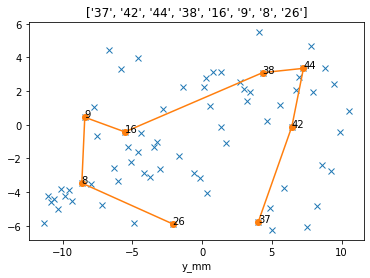

Internal-count,xmm,ymm,RA,DEC,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
37,4.02636,-5.77259,252.945648,34.833462,-523.1213150513944,27.561599999989994,523.8468784441305
42,6.431447,-0.117245,253.122681,34.825806,-302.21174637645277,-33.56280000000709,304.0697308048696
44,7.267641,3.348729,253.224945,34.835129,106.04757730959044,-227.7719999999846,251.24922415248676
38,4.334963,3.091563,253.189056,34.898399,570.1478915500869,-688.870799999998,894.2100409476774
16,-5.545143,-0.426152,252.995956,35.089752,14.42808357330323,-256.01040000000523,256.4166424079391
9,-8.420053,0.443957,252.991058,35.160866,319.43351702815806,97.39439999999888,333.9512553537392
8,-8.63111,-3.466157,252.882523,35.133812,2.7880786930918395,593.3700000000016,593.3765501625429
26,-2.111124,-5.892199,252.881576,34.968987,0.0,0.0,0.0
26,-2.111124,-5.892199,252.881576,34.968987,-2.79371117702025,-593.3700000000016,593.37657665444


In [55]:
#from guider2UV.guider2UV import Guider2UV
slits = ['37', '42', '44', '38', '16', '9', '8', '26'] 
F1=F2
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

ra,dec = "RA", "DEC"

plt.figure()
plt.plot(F1["xmm"],F1["ymm"],"x")
plt.plot(selected_slits["xmm"],selected_slits["ymm"],"-o")
for s in selected_slits:
    plt.text(s["xmm"],s["ymm"],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title(slits)
plt.show()

selected_slits = selected_slits['Internal-count',"xmm","ymm",ra,dec]
slit_path = vstack((selected_slits,selected_slits[::-1]) )
# slit_path["ra_diff"] = [0] + list((slit_path[ra][1:] - slit_path[ra][:-1])*np.cos(slit_path[dec][:-1]*np.pi/180)) 
# slit_path["dec_diff"] = [0] + list((slit_path[dec][1:] - slit_path[dec][:-1])) 
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

In [56]:

movs, flags, slits_coord = G2UV.compute_autocoll_moves_slits(slits, F2, hystcomp = True)

slit position in mm on mask: [ 4.02636 -5.77259]
slit position in mm on mask: [ 6.431447 -0.117245]
slit position in mm on mask: [7.267641 3.348729]
slit position in mm on mask: [4.334963 3.091563]
slit position in mm on mask: [-5.545143 -0.426152]
slit position in mm on mask: [-8.420053  0.443957]
slit position in mm on mask: [-8.63111  -3.466157]
slit position in mm on mask: [-2.111124 -5.892199]

targets local coords in siderostat local frame:
EL: 87.8 arcsec ; CE: 209.1 arcsec
EL: 327.5 arcsec ; CE: 307.7 arcsec
EL: 474.3 arcsec ; CE: 341.9 arcsec
EL: 463.0 arcsec ; CE: 220.8 arcsec
EL: 313.0 arcsec ; CE: -186.6 arcsec
EL: 349.5 arcsec ; CE: -305.6 arcsec
EL: 183.9 arcsec ; CE: -314.0 arcsec
EL: 82.0 arcsec ; CE: -44.3 arcsec

siderostat moves sequence: 


In [57]:
movs.sum(axis=0)

array([1.42108547e-14, 0.00000000e+00])

observed slits position :

In [58]:
slits_coord_obs_det = np.array([
       [2075.0313332 ,  547.1837469 ],
       [1694.46040086,  364.12707452],
       [1459.24135094,  304.18536352],
       [1481.23050022,  524.06001572],
       [1725.16305356, 1277.10559979],
       [1666.1004412 , 1498.52502653],
       [1927.08650574, 1511.38206425],
       [2088.18460048, 1014.57232211],
       [2088.07680252, 1009.05912876],
       [1926.62694293, 1515.59833999],
       [1665.40137023, 1502.45267976],
       [1724.7718892 , 1281.98014583],
       [1480.597437  ,  530.26551288],
       [1457.9982084 ,  300.01849547],
       [1692.86385774,  359.28314686],
       [2073.83585872,  541.7236364 ]])


slits_coord_obs_det

array([[2075.0313332 ,  547.1837469 ],
       [1694.46040086,  364.12707452],
       [1459.24135094,  304.18536352],
       [1481.23050022,  524.06001572],
       [1725.16305356, 1277.10559979],
       [1666.1004412 , 1498.52502653],
       [1927.08650574, 1511.38206425],
       [2088.18460048, 1014.57232211],
       [2088.07680252, 1009.05912876],
       [1926.62694293, 1515.59833999],
       [1665.40137023, 1502.45267976],
       [1724.7718892 , 1281.98014583],
       [1480.597437  ,  530.26551288],
       [1457.9982084 ,  300.01849547],
       [1692.86385774,  359.28314686],
       [2073.83585872,  541.7236364 ]])

In [59]:
valid = np.isfinite(slits_coord_obs_det[:,0])
#valid = np.array([True]*8 + [False]*8)
obs_wave = G2UV.mask_det_map.w[0]
print("wave: ", obs_wave)

slits_coord_valid = [slits_coord[i] for i in np.nonzero(valid)[0]]
slits_valid = np.array(slits + slits[::-1])[valid]

wave:  0.20255


In [60]:
slits_coord_valid

[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39837843, 36.42897653)>): (lon, lat) in deg
     [(0.04893897, -0.11956206)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39837843, 36.42897653)>): (lon, lat) in deg
     [(0.18261289, -0.17596011)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39837843, 36.42897653)>): (lon, lat) in deg
     [(0.26451288, -0.19553401)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39837843, 36.42897653)>): (lon, lat) in deg
     [(0.25821115, -0.12624249)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39837843, 36.42897653)>): (lon, lat) in deg
     [(0.17454844, 0.1067224)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39837843, 36.42897653)>):

In [61]:
mid  = len(slits_coord_obs_det)//2
pair_diff = slits_coord_obs_det[:mid] - slits_coord_obs_det[::-1][:mid]
pair_diff
plt.figure()
plt.subplot('120')
plt.plot(pair_diff[:,0],'*')
plt.plot(np.abs(pair_diff[:,0]),'-')
plt.title("El pair diff")
plt.ylabel("El arcsec")
plt.subplot('121')
plt.plot(pair_diff[:,1],'*')
plt.plot(np.abs(pair_diff[:,1]),'-')
plt.title("Ce pair diff")
plt.ylabel("Ce arcsec")


ValueError: Single argument to subplot must be a three-digit integer, not '120'

<Figure size 432x288 with 0 Axes>

In [62]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )


Fitting rotation, translation and magnification
gamma: 1.0040019827024307
theta: 3.041711166981571 arcmin
dx: -6.036699495989602 arcsec
dy: -0.6268739196853002 arcsec
variances: [4.15678072e-04 1.42899595e+00 3.45995123e-01 3.45995123e-01]

residuals in arcsec: [[-1.24643378  4.36367746]
 [-0.91066201  0.89015133]
 [-0.17710793  2.8578891 ]
 [-0.19284725 -2.3004637 ]
 [-0.67749448 -2.90049624]
 [-0.06161603 -1.85816349]
 [ 0.74738917 -3.27839866]
 [-1.32910726  2.68807186]
 [-1.2226843  -3.41045802]
 [ 1.29468861  1.38323624]
 [ 0.79168381  2.49493922]
 [-0.18513738  2.49317325]
 [ 0.71477842  4.55138014]
 [ 1.27462443 -1.75877315]
 [ 0.98721793 -4.48835976]
 [ 0.19270804 -1.72740559]]
max residual in EL,CE 1.3, 4.6 arcsec
mean residual in EL,CE 0.9, 2.9 arcsec


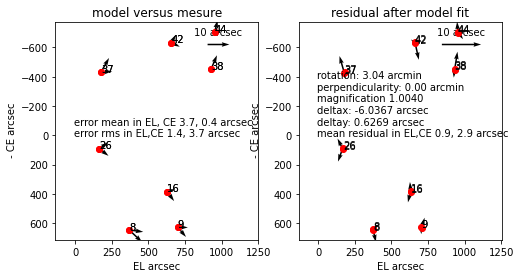

In [63]:
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)

G2UVcor,residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, labels=slits_valid, plot=True)

In [64]:
#G2UVcor.save(filename=cloudpath + 'TestsFTS2018-Flight/E2E-AIT-Flight/XYCalibration/F2_180904.pkl')

In [89]:
moves, flags, slits_coord_new = G2UVcor.compute_autocoll_moves_slits(slits, F2, hystcomp = True)
CEg, Elg = 1.02928, 1.00379 
from astropy.table import hstack
moves = Table.from_pandas(pd.DataFrame( np.hstack((moves,flags[:,None]))  , columns=["EL","CE","UV_image"]))
# print(moves)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]
moves["UV_image"] = moves["UV_image"].astype(bool)
new_cat = hstack((slit_path,moves[moves["UV_image"]][1:-1]))
new_cat
new_cat["EL_moves"] =  list(new_cat["EL_abs"][1:] - new_cat["EL_abs"][:-1]) +  [0]
new_cat["CE_moves"] =  list(new_cat["CE_abs"][1:] - new_cat["CE_abs"][:-1]) +  [0]



new_cat["El_sky_unrot"] = new_cat["EL_moves"]  * 2 * Elg 
new_cat["Cel_sky_unrot"] = new_cat["CE_moves"] * 2 * CEg 
# new_cat["El_sky"] = new_cat["CE_moves"]  * 2 * Elg 
# new_cat["Cel_sky"] = new_cat["EL_moves"] * 2 * CEg 

angle=70*np.pi/180
new_cat["El_sky"] = np.cos(angle) * new_cat["El_sky_unrot"] -  new_cat["Cel_sky_unrot"]*np.sin(angle)
new_cat["Cel_sky"] =  np.sin(angle) * new_cat["El_sky_unrot"] +  new_cat["Cel_sky_unrot"]*np.cos(angle)
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
new_cat.to_pandas().to_clipboard()
new_cat#["ra_diff","dec_diff","EL_moves","CE_moves","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]

slit position in mm on mask: [ 4.02636 -5.77259]
slit position in mm on mask: [ 6.431447 -0.117245]
slit position in mm on mask: [7.267641 3.348729]
slit position in mm on mask: [4.334963 3.091563]
slit position in mm on mask: [-5.545143 -0.426152]
slit position in mm on mask: [-8.420053  0.443957]
slit position in mm on mask: [-8.63111  -3.466157]
slit position in mm on mask: [-2.111124 -5.892199]

targets local coords in siderostat local frame:
EL: 85.3 arcsec ; CE: 210.2 arcsec
EL: 326.0 arcsec ; CE: 309.0 arcsec
EL: 473.5 arcsec ; CE: 343.2 arcsec
EL: 462.1 arcsec ; CE: 221.6 arcsec
EL: 311.1 arcsec ; CE: -187.3 arcsec
EL: 347.6 arcsec ; CE: -306.8 arcsec
EL: 181.3 arcsec ; CE: -315.1 arcsec
EL: 79.3 arcsec ; CE: -44.2 arcsec

siderostat moves sequence: 


/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_41637/3268944343.py:25: RuntimeWarning: invalid value encountered in true_divide
  new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_41637/3268944343.py:26: RuntimeWarning: invalid value encountered in true_divide
  new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
/var/folders/m8/f6l41h_51qxdzrz8p1xqr3f80000gp/T/ipykernel_41637/3268944343.py:27: RuntimeWarning: invalid value encountered in true_divide
  new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]


Internal-count,xmm,ymm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,UV_image,EL_abs,CE_abs,EL_moves,CE_moves,El_sky_unrot,Cel_sky_unrot,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
37,4.02636,-5.77259,252.945648,34.833462,-523.1213150513944,27.561599999989994,523.8468784441305,85.29151616561498,210.1563729742276,True,85.29151616561498,210.1563729742276,240.75428541329237,98.815929885141,483.33348831001746,203.41852062435586,-25.841093816005667,523.7581439226732,524.3952282915352,1.0010467750596002,-0.9375759685945319,-1.001217363645785
42,6.431447,-0.117245,253.122681,34.825806,-302.21174637645277,-33.56280000000709,304.0697308048696,240.7542854132924,98.81592988514099,True,326.04580157890734,308.9723028593686,147.48265438170557,34.24059174028946,296.08322728362447,70.48631253289027,35.030960078305554,302.3349625318959,304.3576805884332,1.0009469860179814,-1.0437436709183427,-1.0004077146468344
44,7.267641,3.348729,253.224945,34.835129,106.04757730959044,-227.7719999999846,251.24922415248676,147.48265438170557,34.24059174028946,True,473.5284559606129,343.21289459965806,-11.455914458746122,-121.65214078245799,-22.99866474908954,-250.4282309291367,227.45955402679652,-107.26317498782547,251.48208172062286,1.0009267991529986,-0.9986282511757895,-1.0114627576515611
38,4.334963,3.091563,253.189056,34.898399,570.1478915500869,-688.870799999998,894.2100409476774,-11.45591445874613,-121.65214078245799,True,462.0725415018668,221.56075381720007,-150.99615611708623,-408.9093433901625,-303.13686309753996,-841.7644179292529,687.32089860435,-572.7558602075577,894.6839067851788,1.0005299267686585,-0.9977500840569117,-1.0045741967937132
16,-5.545143,-0.426152,252.995956,35.089752,14.42808357330323,-256.01040000000523,256.4166424079391,-150.9961561170862,-408.9093433901625,True,311.07638538478056,-187.34858957296245,36.54220994414402,-119.48160116088542,73.36140983966465,-245.96004488575227,256.2179190952474,-15.186114327429337,256.66756735876174,1.0009785829362177,-1.0008105885356304,-1.0525385613602014
9,-8.420053,0.443957,252.991058,35.160866,319.43351702815806,97.39439999999888,333.9512553537392,36.542209944144005,-119.48160116088539,True,347.6185953289246,-306.83019073384787,-166.32243684598092,-8.247355467904015,-333.9055977632544,-16.97767607200849,-98.24864348127151,-319.57533346072296,334.33694037967484,1.0011549141371758,-1.0087709712393387,-1.0004439622801147
8,-8.63111,-3.466157,252.882523,35.133812,2.7880786930918395,593.3700000000016,593.3765501625429,-166.32243684598092,-8.247355467904033,True,181.29615848294367,-315.0775462017519,-101.99455144449718,270.8488994479924,-204.76222158894365,557.5587104476592,-593.9666102381052,-1.7172385830758685,593.9690926185439,1.0009985943257087,-1.0010054607379941,-0.615921848737898
26,-2.111124,-5.892199,252.881576,34.968987,0.0,0.0,0.0,-101.99455144449718,270.8488994479924,True,79.30160703844649,-44.228646753759506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,nan,nan
26,-2.111124,-5.892199,252.881576,34.968987,-2.79371117702025,-593.3700000000016,593.37657665444,0.0,-30.0,True,79.30160703844649,-44.228646753759506,101.99455144449718,-270.8488994479924,204.76222158894365,-557.5587104476592,593.9666102381052,1.7172385830758685,593.9690926185439,1.0009985496351146,-1.0010054607379941,-0.6146800704385846


## Star sequence

gc - s36 - s40 - s46 - s21


In [93]:
star_target_path = cloudpath + 'Target_selection/GuidingStars/'
F2_stars = Table.read(star_target_path + "F2_guidingstars.fits", format='fits')

stars = [36, 40, 46, 21 ]

#F2_stars_coords = coordinates.SkyCoord(F2_stars['RA']*u.deg, F2_stars['DEC']*u.deg)

star_movs, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F2_stars, hystcomp = True)


star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(252.895501, 34.875333)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(252.83754, 34.836825)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(252.787662, 34.810634)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(252.829951, 34.945769)]>

targets local coords in siderostat local frame:
EL: 41.7 arcsec ; CE: 116.7 arcsec
EL: -62.0 arcsec ; CE: 151.7 arcsec
EL: -147.1 arcsec ; CE: 170.4 arcsec
EL: -6.0 arcsec ; CE: -31.1 arcsec

siderostat moves sequence: 
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: False
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: True
EL: 41.7 arcsec ; CE 116.7 arcsec ; image: True
EL: -103.7 arcsec ; CE 35.0 arcsec ; image: True
EL: -85.0 arcsec ; CE 18.6 arcsec ; image: True
EL: 141.1 arcsec ; CE -201.5 arcsec ; image: True
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: False
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: True
EL: -141.1 arcsec ; CE 231.5 arcsec ; i

In [94]:
stars_coord

[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39837843, 36.42897653)>): (lon, lat) in deg
     [(0.02323068, -0.06674584)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39837843, 36.42897653)>): (lon, lat) in deg
     [(-0.03460088, -0.08676068)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39837843, 36.42897653)>): (lon, lat) in deg
     [(-0.08202328, -0.09742144)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.39837843, 36.42897653)>): (lon, lat) in deg
     [(-0.00332875, 0.01778478)]>]

------------------------------------------------------